In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import numpy as np
import lmdb
import torchaudio
import librosa
from udls.generated import AudioExample
import IPython.display as ipd
import logging
from tqdm import tqdm
from pathlib import Path
from typing import Callable, Optional
from torch.utils.tensorboard import SummaryWriter
import warnings
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)
logging.basicConfig(
    format="[%(asctime)s] %(levelname)s(%(name)s)\t%(message)s", level=logging.INFO
)

device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info("device: %s", device)


[2024-01-16 14:50:04,315] INFO(root)	device: cuda


In [3]:
# dataset definition
class LoopDataset(torch.utils.data.Dataset):
    FS = 44100
    SIZE_SAMPLES = 65536

    def __init__(self, db_path: str) -> None:
        super().__init__()

        self._db_path = db_path

        self.env = lmdb.open(self._db_path, lock=False)

        with self.env.begin(write=False) as txn:
            self.keys = list(txn.cursor().iternext(values=False))

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx: int):
        with self.env.begin(write=False) as txn:
            ae = AudioExample.FromString(txn.get(self.keys[idx]))

        buffer = ae.buffers["waveform"]
        assert buffer.precision == AudioExample.Precision.INT16
        assert buffer.sampling_rate == self.FS

        audio = torch.frombuffer(buffer.data, dtype=torch.int16)
        audio = audio.float() / (2**15 - 1)
        assert len(audio) == self.SIZE_SAMPLES

        return audio


# get 5 random examples
dataset = LoopDataset(db_path="../../../data/")
valid_ratio = 0.2
nb_valid = int(valid_ratio * len(dataset))
nb_train = len(dataset) - nb_valid
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(
    dataset, [nb_train, nb_valid]
)

print(nb_train, nb_valid)

num_threads = 0  # != 0 crashes on windows o_o
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, num_workers=num_threads
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads
)

for i in np.random.randint(len(train_dataset), size=5):
    print(f"example #{i}")
    ipd.display(ipd.Audio(train_dataset[i], rate=LoopDataset.FS))

9195 2298
example #3546


C:\Users\MrGoo\AppData\Local\Temp\ipykernel_44228\3780269852.py:27: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:1514.)
  audio = torch.frombuffer(buffer.data, dtype=torch.int16)


example #4483


example #1416


example #7028


example #2643


In [4]:
# transform definition


# extended from torchaudio.transform.MelSpectrogram
class CustomTransform(nn.Module):
    __constants__ = [
        "sample_rate",
        "n_fft",
        "win_length",
        "hop_length",
        "pad",
        "power",
        "normalized",
        "n_mels",
        "f_max",
        "f_min",
        "norm",
        "mel_scale",
        "n_stft",
    ]

    def __init__(
        self,
        sample_rate: int = 16000,
        n_fft: int = 400,
        win_length: Optional[int] = None,
        hop_length: Optional[int] = None,
        f_min: float = 0.0,
        f_max: Optional[float] = None,
        pad: int = 0,
        n_mels: int = 128,
        window_fn: Callable[..., torch.Tensor] = torch.hann_window,
        normalized: bool = False,
        wkwargs: Optional[dict] = None,
        center: bool = True,
        pad_mode: str = "reflect",
        norm: Optional[str] = None,
        griffin_lim_iter=32,
        griffin_lim_momentum=0.99,
    ):
        super(CustomTransform, self).__init__()

        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else self.win_length // 2
        self.pad = pad
        self.normalized = normalized
        self.center = center
        self.n_mels = n_mels  # number of mel frequency bins
        self.f_max = f_max
        self.f_min = f_min
        self.norm = norm
        self.n_stft = self.n_fft // 2 + 1

        self.spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=self.n_fft,
            win_length=self.win_length,
            hop_length=self.hop_length,
            pad=self.pad,
            window_fn=window_fn,
            power=None,  # get complex spectrogram
            normalized=self.normalized,
            wkwargs=wkwargs,
            center=center,
            pad_mode=pad_mode,
            onesided=True,
        )
        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=self.n_mels,
            sample_rate=self.sample_rate,
            f_min=self.f_min,
            f_max=self.f_max,
            n_stft=self.n_stft,
            norm=self.norm,
            mel_scale="htk",
        )
        self.inv_mel_scale = torchaudio.transforms.InverseMelScale(
            n_mels=self.n_mels,
            sample_rate=self.sample_rate,
            f_min=self.f_min,
            f_max=self.f_max,
            n_stft=self.n_stft,
            norm=self.norm,
            mel_scale="htk",
            driver="gelsd"
            # see https://pytorch.org/docs/stable/generated/torch.linalg.lstsq.html
            # safest option seems "gelsd", but does not work on CUDA
            # "gels" should be used (default), but it crashes because the matrix that goes in is not full rank. why ?
        )
        self.inv_spectrogram = torchaudio.transforms.InverseSpectrogram(
            n_fft=self.n_fft,
            win_length=self.win_length,
            hop_length=self.hop_length,
            pad=self.pad,
            window_fn=window_fn,
            normalized=self.normalized,
            wkwargs=wkwargs,
            center=center,
            pad_mode=pad_mode,
            onesided=True,
        )
        self.griffin_lim = torchaudio.transforms.GriffinLim(
            n_fft=self.n_fft,
            n_iter=griffin_lim_iter,
            win_length=self.win_length,
            hop_length=self.hop_length,
            window_fn=window_fn,
            power=1,  # magnitude spectrogram
            wkwargs=wkwargs,
            momentum=0.99,
        )

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        specgram = self.spectrogram(waveform)  # Dimension: (…, freq, time)
        mag, phase = torch.abs(specgram), torch.angle(specgram)
        mel_specgram = self.mel_scale(mag)  # dimension: (…, n_mels, time)
        log_mel_specgram = torch.log(1 + mel_specgram)
        return log_mel_specgram, phase

    def backward(
        self, log1p_mel_specgram: torch.Tensor, phase: torch.Tensor = None
    ) -> torch.Tensor:
        mel_specgram = torch.expm1(log1p_mel_specgram)

        # FIXME: tensor must be on cpu due to problem in inv_mel_scale :(
        # we force calculation on cpu and copy back to gpu
        self.inv_mel_scale = self.inv_mel_scale.cpu()
        device = mel_specgram.device
        mag = self.inv_mel_scale(mel_specgram.cpu())
        mag = mag.to(device)

        if phase is None:  # reconstruct phase
            # TODO: use other (better) reconstruction methods ?
            waveform = self.griffin_lim(mag)
        else:  # copy original phase
            specgram = mag * torch.exp(1j * phase)
            waveform = self.inv_spectrogram(specgram)
        return waveform

    def get_n_frames(self, n_samples: int):
        # see https://pytorch.org/docs/stable/generated/torch.stft.html
        if self.center:
            return 1 + n_samples // self.hop_length
        else:
            return 1 + (n_samples - self.n_fft) // self.hop_length


# test: forward then backward
ipd.display(ipd.Audio(dataset[7809], rate=LoopDataset.FS))
t = CustomTransform(
    sample_rate=LoopDataset.FS,
    n_mels=512,
    n_fft=1024,
    griffin_lim_iter=64,
    hop_length= 64
).to(device)
spec, phase = t.forward(dataset[7809].to(device))
print(spec.shape, phase.shape)
#plot_spectrogram(spec.cpu())
transformed_transformed_copyphase = t.backward(spec, phase)
transformed_transformed_griffinlim = t.backward(spec)
ipd.display(ipd.Audio(transformed_transformed_copyphase.cpu(), rate=LoopDataset.FS))
ipd.display(ipd.Audio(transformed_transformed_griffinlim.cpu(), rate=LoopDataset.FS))

c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


torch.Size([512, 1025]) torch.Size([513, 1025])


In [5]:
def outsize(Lin, stride, pad, ker):
    temp = Lin -(ker-1) -1 +2*pad
    temp /= stride
    lout = np.floor(temp) +1
    return(lout)

In [6]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims))
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        
        x_encoded = self.encoder(x)

        mu = self.mu(x_encoded)
        sigma = self.sigma(x_encoded)

        return (mu, sigma)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div
    
    def latent(self, z_params):
        
        normal = distrib.Normal(loc=0., scale=1.)
        mu, sigma = z_params
        kl_div = torch.sum(1 + torch.log(sigma**2) - mu**2 - 2*(sigma**2))/2
        z = mu + sigma * normal.sample(sigma.shape).to(device)
    
        return z, kl_div

In [8]:
class CouchePrint(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x.shape)

        return(x)

In [9]:
def construct_encoder_decoder(n_latent = 16, n_hidden = 1024):
    # Encoder network
    encoder = nn.Sequential(
        nn.Conv1d(128, 64,7,2, 3), nn.LeakyReLU(), nn.BatchNorm1d(64),
        nn.Conv1d(64, 32,7,2,3), nn.LeakyReLU(), nn.BatchNorm1d(32),
        nn.Conv1d(32, 16,7,4,3), nn.LeakyReLU(), nn.BatchNorm1d(16), 
        nn.Flatten()
    )

    # Decoder network
    decoder = nn.Sequential(
        nn.Linear(n_latent,n_hidden), nn.LeakyReLU(),
        nn.Unflatten(1, torch.Size([n_latent, int(n_hidden/n_latent)])),
        nn.ConvTranspose1d(16,32,8,4,2), nn.LeakyReLU(), nn.BatchNorm1d(32),
        nn.ConvTranspose1d(32,64,8,2,3), nn.LeakyReLU(), nn.BatchNorm1d(64),
        nn.ConvTranspose1d(64,128,8,2,3), nn.LeakyReLU(), nn.BatchNorm1d(128),
    )
    return encoder, decoder

In [10]:
encoder_test, decoder_test = construct_encoder_decoder(n_hidden = 1024, n_latent = 16)

In [11]:
model_test = VAE(encoder_test, decoder_test, 1024, 16).to(device)

In [12]:
im_test = torch.ones((128,128,1024)).to(device)

In [13]:
out_test,_ = model_test(im_test)

In [14]:
out_test.shape

torch.Size([128, 128, 1024])

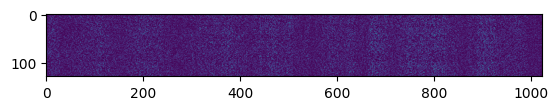

In [15]:
plt.imshow(out_test[0].detach().cpu())

In [16]:
n_epochs = 50
n_latent = 16
n_hidden = 1024
n_mels = 128
beta = 1
generate_every_nth_epoch = 5
evaluate_every_nth_epoch = 5

transform = CustomTransform(
    sample_rate=LoopDataset.FS,
    n_mels=n_mels,
    n_fft=1024,
    griffin_lim_iter=64,
    hop_length=64
).to(device)

n_frames = transform.get_n_frames(LoopDataset.SIZE_SAMPLES)

print("n_mels", n_mels)
print("n_frames", n_frames)

# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(n_hidden = n_hidden, n_latent = n_latent)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
recons_criterion = torch.nn.MSELoss(reduction="sum")

n_mels 128
n_frames 1025


c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [17]:
filename = "audiovae_test0.pt"
logger.info("training %s", filename)
logger.info("n_epochs=%d", n_epochs)

WRITER = SummaryWriter(comment=filename)

[2024-01-16 14:50:22,804] INFO(__main__)	training audiovae_test0.pt
[2024-01-16 14:50:22,806] INFO(__main__)	n_epochs=50


In [124]:
for epoch in range(1, n_epochs + 1):
    # Forward pass: compute predicted y by passing x to the model.
    model.train()
    logger.info("training")

    full_loss = 0
    recons_loss = 0
    kl_div = 0

    for i, waveform in tqdm(enumerate(train_loader), desc="Train"):
        
        waveform = waveform.to(device)
        mag, phase = transform.forward(waveform)
        mag = mag[:,:,:mag.shape[2]-1]


        mag_tilde, kl_div_batch = model(mag)
        
        recons_loss_batch = recons_criterion(mag_tilde, mag)
        full_loss_batch = recons_loss_batch - beta * kl_div_batch
        
        recons_loss += recons_loss_batch
        full_loss += full_loss_batch
        kl_div += kl_div_batch
        
        optimizer.zero_grad()
        full_loss_batch.backward()
        optimizer.step()

    WRITER.add_scalar("loss/train/full", full_loss, epoch)
    WRITER.add_scalar("loss/train/reconstruction", recons_loss, epoch)
    WRITER.add_scalar("loss/train/kl_div", kl_div, epoch)


[2024-01-16 15:08:54,476] INFO(__main__)	training
Train: 72it [00:05, 13.77it/s]
[2024-01-16 15:08:59,719] INFO(__main__)	training
Train: 72it [00:04, 15.61it/s]
[2024-01-16 15:09:04,348] INFO(__main__)	training
Train: 72it [00:04, 15.45it/s]
[2024-01-16 15:09:09,018] INFO(__main__)	training
Train: 72it [00:04, 15.64it/s]
[2024-01-16 15:09:13,636] INFO(__main__)	training
Train: 72it [00:04, 15.48it/s]
[2024-01-16 15:09:18,305] INFO(__main__)	training
Train: 72it [00:04, 15.72it/s]
[2024-01-16 15:09:22,900] INFO(__main__)	training
Train: 72it [00:04, 15.34it/s]
[2024-01-16 15:09:27,610] INFO(__main__)	training
Train: 72it [00:04, 15.28it/s]
[2024-01-16 15:09:32,335] INFO(__main__)	training
Train: 72it [00:04, 15.51it/s]
[2024-01-16 15:09:36,991] INFO(__main__)	training
Train: 72it [00:04, 15.55it/s]
[2024-01-16 15:09:41,636] INFO(__main__)	training
Train: 72it [00:04, 15.36it/s]
[2024-01-16 15:09:46,340] INFO(__main__)	training
Train: 72it [00:04, 15.32it/s]
[2024-01-16 15:09:51,050] IN

In [134]:
test = torch.arange(0,16, dtype=torch.get_default_dtype()).reshape(1,-1).to(device)

In [125]:
test = torch.ones(1,16).to(device)

In [176]:
c = 5

if c == 0:
    test = torch.zeros(1,16).to(device)
elif c == 1:
    test = torch.ones(1,16).to(device)
elif c == 2:
    test = torch.arange(0,16, dtype=torch.get_default_dtype()).reshape(1,-1).to(device)
else:
    test = torch.randn((1,16)).to(device)

In [177]:
test

tensor([[ 0.2539, -2.7939, -0.2161,  0.2107,  1.2607,  0.8525, -0.4650, -0.1537,
          0.2561,  1.1734,  0.6798, -2.1769, -1.1345, -0.9553, -0.0784, -1.6385]],
       device='cuda:0')

In [178]:
test_output = model.decoder(test)

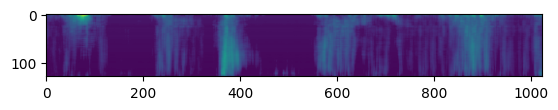

In [179]:
plt.imshow(test_output[0].detach().cpu())

In [180]:
test_wave = transform.backward(test_output)

In [181]:
test_wave.shape

torch.Size([1, 65472])

In [182]:
ipd.Audio(test_wave.cpu().detach(), rate=LoopDataset.FS)

In [19]:
# # training loop

# # parameters
# n_epochs = 50
# beta_interval = (0, 1)  # min, max
# beta_epoch_interval = (10, 40)  # start, end
# evaluate_every_nth_epoch = 3
# generate_every_nth_epoch = 3
# n_latent = 16
# n_mels = 128
# transform = CustomTransform(
#     sample_rate=LoopDataset.FS,
#     n_mels=n_mels,
#     n_fft=1024,
#     griffin_lim_iter=64,
#     hop_length=64
# ).to(device)
# n_frames = transform.get_n_frames(LoopDataset.SIZE_SAMPLES)
# n_in = n_mels * n_frames

# print("n_mels", n_mels)
# print("n_frames", n_frames)
# print("n_in", n_in)

# filename = f"audiovae_{beta_interval[0]}_{beta_interval[1]}_{n_epochs}.pt"
# logger.info("training %s", filename)
# logger.info("n_epochs=%d", n_epochs)

# model = VAE(encoder, decoder, n_hidden, n_latent).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# recons_criterion = torch.nn.MSELoss(reduction="sum")

# if Path(filename).exists():
#     model.load_state_dict(torch.load(filename))
#     logger.info("loaded from", filename)

# else:
#     WRITER = SummaryWriter(comment=filename)

#     for epoch in range(n_epochs):
#         #beta = beta_warmup(epoch, beta_interval, beta_epoch_interval)
#         beta = 1
#         logger.info(
#             f"epoch {epoch+1}/{n_epochs}; beta={beta:.2f}; {epoch * len(train_dataset)} examples seen"
#         )
#         WRITER.add_scalar("beta", beta, epoch)

#         logger.info("training")
#         model.train()
#         full_loss = 0
#         recons_loss = 0
#         kl_div = 0
#         for i, waveform in tqdm(enumerate(train_loader), desc="Train"):
#             optimizer.zero_grad()
#             waveform = waveform.to(device)
#             mag, phase = transform.forward(waveform)
#             mag = mag[:,:,:mag.shape[2]-1]
#             mag_tilde, kl_div_batch = model(mag)
#             recons_loss_batch = recons_criterion(mag_tilde, mag)
#             full_loss_batch = recons_loss_batch - beta * kl_div_batch
#             recons_loss += recons_loss_batch
#             full_loss += full_loss_batch
#             kl_div += kl_div_batch
#             full_loss_batch.backward()
#             optimizer.step()
#         WRITER.add_scalar("loss/train/full", full_loss, epoch)
#         WRITER.add_scalar("loss/train/reconstruction", recons_loss, epoch)
#         WRITER.add_scalar("loss/train/kl_div", kl_div, epoch)

#         if epoch % evaluate_every_nth_epoch == 0 or epoch == n_epochs - 1:
#             logger.info("evaluating")
#             model.eval()
#             full_loss = 0
#             recons_loss = 0
#             kl_div = 0
#             for i, waveform in tqdm(enumerate(valid_loader), desc="Evaluation"):
#                 optimizer.zero_grad()
#                 waveform = waveform.to(device)
#                 mag, phase = transform.forward(waveform)
#                 mag = mag[:,:,:mag.shape[2]-1]
#                 mag_tilde, kl_div_batch = model(mag)
#                 recons_loss_batch = recons_criterion(mag_tilde, mag)
#                 full_loss_batch = recons_loss_batch - beta * kl_div_batch
#                 recons_loss += recons_loss_batch
#                 full_loss += full_loss_batch
#                 kl_div += kl_div_batch
#                 full_loss_batch.backward()
#                 optimizer.step()
#             WRITER.add_scalar("loss/eval/full", full_loss, epoch)
#             WRITER.add_scalar("loss/eval/reconstruction", recons_loss, epoch)
#             WRITER.add_scalar("loss/eval/kl_div", kl_div, epoch)

#         # if epoch % generate_every_nth_epoch == 0 or epoch == n_epochs - 1:
#         #     logger.info("generating from dataset")
#         #     with torch.no_grad():
#         #         n_sounds = 4
#         #         waveform = next(iter(valid_loader)).to(device)
#         #         mag, phase = transform.forward(waveform[:n_sounds])
#         #         print(f"{mag.shape=}")
#         #         print(f"{phase.shape=}")
#         #         mag = mag[:,:,:mag.shape[2]-1]
#         #         phase = phase[:,:,:phase.shape[2]-1]
#         #         print(f"{mag_tilde.shape=}")
#         #         print(f"{phase.shape=}")
#         #         mag_tilde, _ = model(mag)
#         #         mag_tilde = mag_tilde.reshape(-1, 1, n_mels, n_frames-1)
#         #         phase = phase.reshape(-1, 1, n_mels, n_frames-1)
#         #         print(f"{mag_tilde.shape=}")
#         #         print(f"{phase.shape=}")
#         #         grid = torchvision.utils.make_grid(mag_tilde, n_sounds)
#         #         WRITER.add_image("gen/dataset/melspec", grid)

#         #         waveform_tilde_copyphase = transform.backward(mag_tilde, phase)
#         #         waveform_tilde_griffinlim = transform.backward(mag_tilde)
#         #         WRITER.add_audio(
#         #             "gen/dataset/copyphase",
#         #             waveform_tilde_copyphase.reshape(-1),
#         #             epoch,
#         #             sample_rate=LoopDataset.FS,
#         #         )
#         #         WRITER.add_audio(
#         #             "gen/dataset/griffinlim",
#         #             waveform_tilde_griffinlim.reshape(-1),
#         #             epoch,
#         #             sample_rate=LoopDataset.FS,
#         #         )

#         #     logger.info("generating random from latent space")
#         #     with torch.no_grad():
#         #         n_sounds = 16
#         #         z = torch.randn(n_sounds, n_latent).to(device)
#         #         mag_tilde = model.decode(z).reshape(-1, 1, n_mels, n_frames-1)
#         #         grid = torchvision.utils.make_grid(mag_tilde, n_sounds)
#         #         WRITER.add_image("gen/rand_latent/melspec", grid)
#         #         waveform_tilde = transform.backward(mag_tilde)
#         #         WRITER.add_audio(
#         #             "gen/rand_latent/griffinlim",
#         #             waveform_tilde_griffinlim.reshape(-1),
#         #             epoch,
#         #             sample_rate=LoopDataset.FS,
#         #         )
#         #     logger.info("exploring latent space")
#         #     # with torch.no_grad():
#             #     n_sounds_per_dimension = 8
#             #     z = torch.zeros(n_sounds_per_dimension * n_latent, n_latent).to(device)
#             #     for i in range(n_latent):
#             #         a = i * n_sounds_per_dimension
#             #         b = (i + 1) * n_sounds_per_dimension
#             #         z[a:b, i] = torch.linspace(-5, +5, n_sounds_per_dimension)
#             #     mag_tilde = model.decode(z).reshape(-1, 1, n_mels, n_frames)
#             #     grid = torchvision.utils.make_grid(mag_tilde, n_sounds_per_dimension)
#             #     WRITER.add_image("gen/explo_latent/melspec", grid)
#             #     waveform_tilde = transform.backward(mag_tilde)
#             #     WRITER.add_audio(
#             #         "gen/explo_latent/griffinlim",
#             #         waveform_tilde_griffinlim.reshape(-1),
#             #         epoch,
#             #         sample_rate=LoopDataset.FS,
#             #    )

#     # save weights
#     torch.save(model.state_dict(), filename)
#     logger.info("saved to %s", filename)

[2024-01-12 18:39:07,408] INFO(__main__)	training audiovae_0_1_50.pt
[2024-01-12 18:39:07,409] INFO(__main__)	n_epochs=50


n_mels 128
n_frames 1025
n_in 131200


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\MrGoo\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\User